### Accompanying notebook for the below paper:

http://iopscience.iop.org/article/10.3847/1538-4357/aa7f2d/meta

* Patrico, Pavlos, Karim

Transfer learning with mixtures of Gaussians.

Types of differences in distributions of features:

Let $X\in \mathcal{X}$ be the a random variable in the feature space and $Y \in \mathcal{Y}$ be a random variable in the feature space.  Then, the source domain is $P_s(X,Y)$ and the target domain is $P_t(X,Y)$.  Our problem is that we cannot directly transfer the model because $P_s(X,Y)\ne P_t(X,Y)$, if this was not the case the model could transfer without any changes. 

##### Covariate shift (sample selection bias):
If $P_s(X,Y)\ne P_t(X,Y)$ and the conditional distributions are the same (i.e. the causal realationship remains the same from source to target), then $P_s(Y|X)=P_t(Y|X)$ and $P_s(X)\ne P_t(X)$  

##### Causal realtionship changes:
Now consider the case where the causal realtionship changes between the source and the target, that is $P_s(Y|X)\ne P_t(Y|X)$.  There are three possibilities that could cause this (by Bayes Thm).  One is when only $P_s(X|Y)\ne P_t(X|Y)$ (conditional shift - the probability of the data given the class changes (i.e. the causal relationship changes), another is when only $P_s(Y)\ne P_t(Y)$ (target shift /class imbalence - the probability of the data given class stayes the same, but the distribution of classes is different)  and the last one is when both are not equal (generalized target shift).

##### Differences from other work:
While other Bayesian techniques transfer on a model and task (in our case, survey) level to a new space not shared by either the source or the target, this method transforms from the source space to the target space. This method is also *classifier invariate*, unlike previously proposed Bayesian methods. 

In [22]:
import numpy as np

def mat_rotate(a,b,theta,n):
    """ Return the rotation matrix based on section 4.4 with inputs a,b for rotation of axis X_a to X_b with 
    angle theta and matrix size of nxn """
    out = np.zeros((n,n))
    np.fill_diagonal(out,1.)
    out[a,b] = -np.sin(theta)
    out[b,a] = np.sin(theta)
    out[a,a] = np.cos(theta)
    out[b,b] = np.cos(theta)
    return out

mat_rotate(2,4,2.4,5)

array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , -0.73739372,  0.        , -0.67546318],
       [ 0.        ,  0.        ,  0.        ,  1.        ,  0.        ],
       [ 0.        ,  0.        ,  0.67546318,  0.        , -0.73739372]])

### Model 

Here is a graphical view of the model proposed for domain adaptation in this paper.

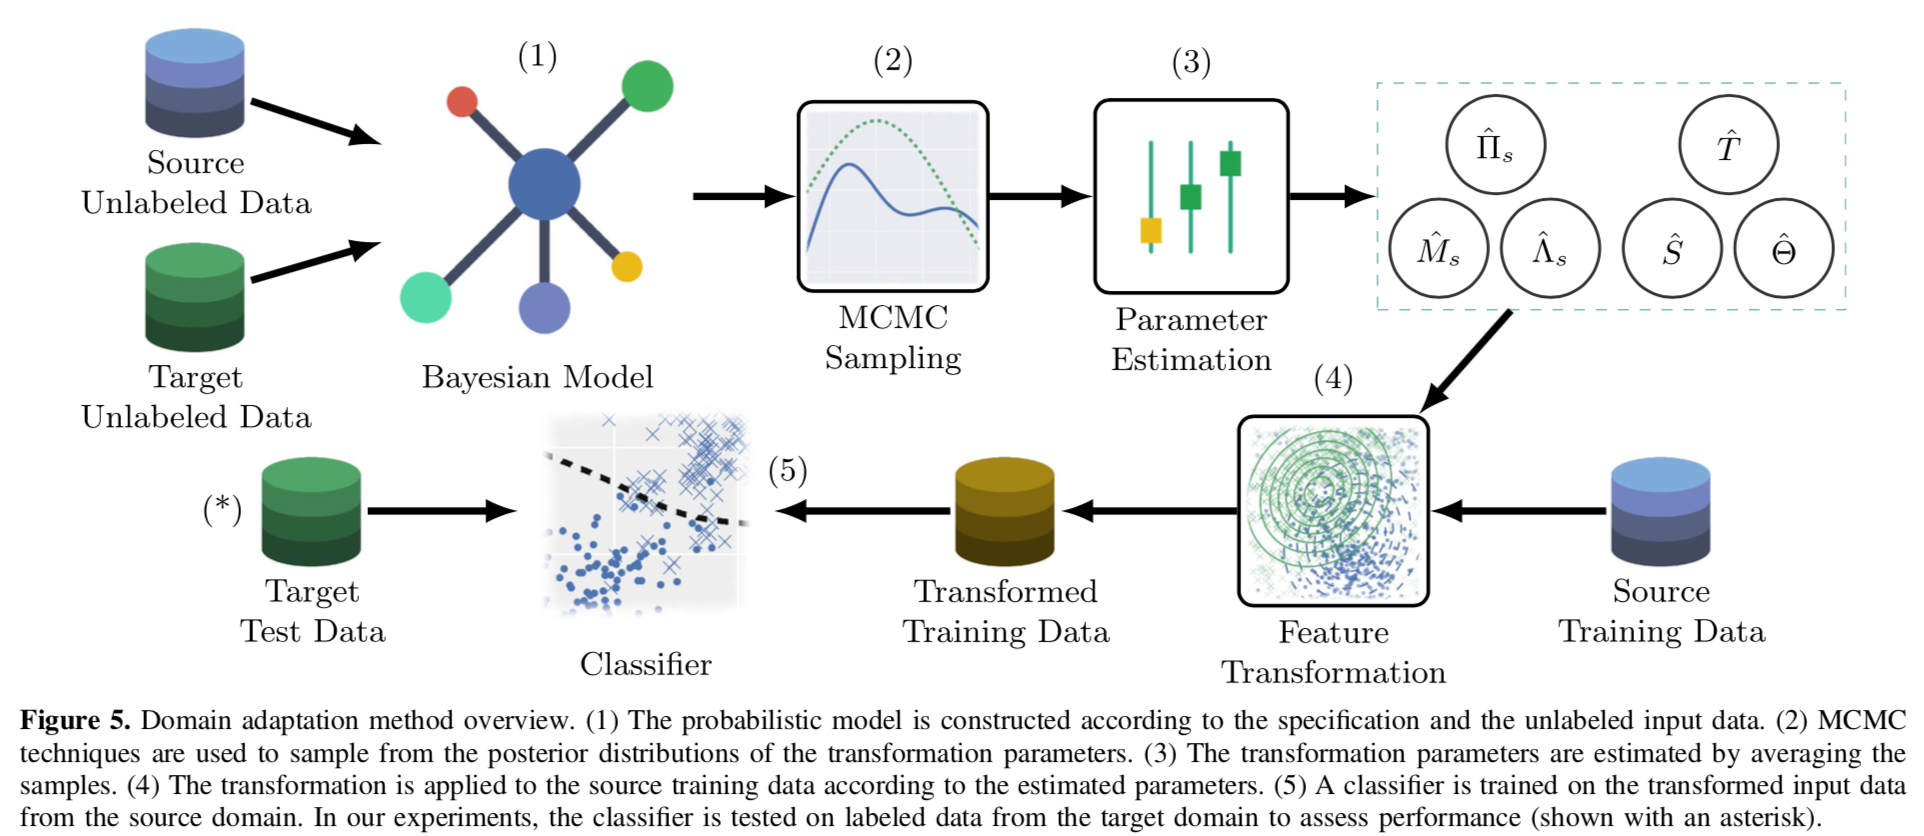

0. One major assumption is that $X_s^i \approx \mathcal{N}(M_s^{Z_s^i}, \Lambda_s^{Z_s^i})$ and $X_t^i \approx \mathcal{N}(M_t^{Z_t^i}, \Lambda_t^{Z_t^i})$.
1. We start the first section with the priors for both the source and the target components. Both are Dirchlet priors initialized with some concentration parameter vector.  The source component weights are determined by the Dirchlet prior and the target component weights are determined by its Dirchlet prior ($H$) *and* the Dirchlet prior for the source weights with the following form: $$\Pi_t^k = \Pi_s^kH^k/\sum^K_{l=1}\Pi_s^lH^l, \forall k$$ The mean of the source is $M_s^k = \mathcal{N}(\mu,\omega)$ when $\mu$ and $\omega$ are provided initial values. The precision matrices of the source are introduced with sampling from the $LKJ(\lambda)$ distribution and then transformation from the covariance matrices to the precision matrices. We then determine the $M_t^k = M_s^k + T^k$ with $T^k = \mathcal{N}(0,\mathcal{k}I)$ and $\mathcal{k}$ is a predetermined parameter that governs the size of the translation. To get the precision matrices we sample from a Beta distribution, $\Theta^k = \big(\mathcal{B}_k^{d \choose 2}(\beta,\beta)-1\big)\rho$ when $\beta, \rho$ are paremeters to be specified.  Then for each $d \choose 2$ plane of rotation we make a rotation matrix which we will refer to as $R^k$.  We also introduce a scaling factor in the range $[0.5, 1.5]$ which we will refer to as $S^k$. Then, the precision matrix of the target is given by the following: $\Lambda_t^k =R^k(S^k)^{-1}\Lambda_s^k(S^k)^{-1}(R_k)^{-1}$.
2. Now that we have determined $\Pi_s$, $M_s$, $\Lambda_s$, $S$, $T$, and $\Theta$ we can use Gibbs sampling to sample from the posteriors above.  We sample and run K-means until the standard deviation goes below a predefined threshold, and then we stop with the mean values and use them as the parameter estimates. Recall that the $T$ matrix increments, the $S$ matrix scales, and the $\Theta$ matrix rotates. We apply this transformation to the source data and now we have data with labels in the target space. 
3. Now that the data with labels is in the target space we just retrain whatever classifier we want and can apply that classifier to the target data.